In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

import AnomalyCLIP_lib
import torch
import argparse
import torch.nn.functional as F
from prompt_ensemble import AnomalyCLIP_PromptLearner
from dataset import Dataset
from logger import get_logger
from tqdm import tqdm
from sklearn.metrics import  precision_score, recall_score

import random
# from tabulate import tabulate
from utils import get_transform

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


from tqdm import tqdm
from scipy.ndimage import gaussian_filter

In [4]:
parser = argparse.ArgumentParser("AnomalyCLIP", add_help=True)
# paths
parser.add_argument("--data_path", type=str, default="./data/crop", help="path to test dataset")
parser.add_argument("--save_path", type=str, default='./results/CP/crop_outlier', help='path to save results')
parser.add_argument("--checkpoint_path", type=str, default='./train_results/0822_crop/epoch_15.pth', help='path to checkpoint')
# model
parser.add_argument("--dataset", type=str, default='crop')
parser.add_argument("--features_list", type=int, nargs="+", default=[6, 12, 18, 24], help="features used")
parser.add_argument("--image_size", type=int, default=518, help="image size")
parser.add_argument("--depth", type=int, default=9, help="image size")
parser.add_argument("--n_ctx", type=int, default=12, help="zero shot")
parser.add_argument("--t_n_ctx", type=int, default=4, help="zero shot")
parser.add_argument("--feature_map_layer", type=int,  nargs="+", default=[0, 1, 2, 3], help="zero shot")
parser.add_argument("--metrics", type=str, default='image-pixel-level')
parser.add_argument("--seed", type=int, default=111, help="random seed")
parser.add_argument("--sigma", type=int, default=4, help="zero shot")

args = parser.parse_args(args=[])

In [5]:
logger = get_logger(args.save_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'device ===> {device}')

device ===> cuda


# Train data

In [6]:
AnomalyCLIP_parameters = {"Prompt_length": args.n_ctx, "learnabel_text_embedding_depth": args.depth, "learnabel_text_embedding_length": args.t_n_ctx}
model, _ = AnomalyCLIP_lib.load("ViT-L/14@336px", device=device, design_details = AnomalyCLIP_parameters)
model.eval()

preprocess, target_transform = get_transform(args)
train_data = Dataset(root=args.data_path, transform=preprocess, target_transform=target_transform, dataset_name = args.dataset, mode='train')
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)
obj_list = train_data.obj_list
print(f'obj_list ===> {obj_list}\n')

train_results = {}
train_metrics = {}
for obj in obj_list:
    train_results[obj] = {}
    train_results[obj]['gt_sp'] = []
    train_results[obj]['pr_sp'] = []
    train_results[obj]['pr_sp_n'] = []
    train_results[obj]['imgs_masks'] = []
    train_results[obj]['anomaly_maps'] = []
    train_metrics[obj] = {}
    train_metrics[obj]['pixel-auroc'] = 0
    train_metrics[obj]['pixel-aupro'] = 0
    train_metrics[obj]['image-auroc'] = 0
    train_metrics[obj]['image-ap'] = 0

prompt_learner = AnomalyCLIP_PromptLearner(model.to("cpu"), AnomalyCLIP_parameters)
checkpoint = torch.load(args.checkpoint_path)
prompt_learner.load_state_dict(checkpoint["prompt_learner"])
prompt_learner.to(device)
model.to(device)
model.visual.DAPM_replace(DPAM_layer = 20)

prompts, tokenized_prompts, compound_prompts_text = prompt_learner(cls_id = None)

text_features = model.encode_text_learn(prompts, tokenized_prompts, compound_prompts_text).float()
text_features = torch.stack(torch.chunk(text_features, dim = 0, chunks = 2), dim = 1)
text_features = text_features/text_features.norm(dim=-1, keepdim=True)
# print(text_features)

model.to(device)
features_list = args.features_list

for idx, items in enumerate(tqdm(train_dataloader)):
    
    image = items['img'].to(device)
    cls_name = items['cls_name']
    cls_id = items['cls_id']
    gt_mask = items['img_mask']
    gt_mask[gt_mask > 0.5], gt_mask[gt_mask <= 0.5] = 1, 0
    train_results[cls_name[0]]['imgs_masks'].append(gt_mask)  # px
    train_results[cls_name[0]]['gt_sp'].extend(items['anomaly'].detach().cpu())

    with torch.no_grad():
        image_features, patch_features = model.encode_image(image, features_list, DPAM_layer = 20)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        text_probs = image_features @ text_features.permute(0, 2, 1)
        text_probs = (text_probs/0.07).softmax(-1)
        text_probs_a = text_probs[:, 0, 1]
        text_probs_n = text_probs[:, 0, 0]
        anomaly_map_list = []
        for idx, patch_feature in enumerate(patch_features):
            if idx >= args.feature_map_layer[0]:
                patch_feature = patch_feature/ patch_feature.norm(dim = -1, keepdim = True)
                similarity, _ = AnomalyCLIP_lib.compute_similarity(patch_feature, text_features[0])
                similarity_map = AnomalyCLIP_lib.get_similarity_map(similarity[:, 1:, :], args.image_size)
                anomaly_map = (similarity_map[...,1] + 1 - similarity_map[...,0])/2.0
                anomaly_map_list.append(anomaly_map)

        anomaly_map = torch.stack(anomaly_map_list)
        
        anomaly_map = anomaly_map.sum(dim = 0)
        train_results[cls_name[0]]['pr_sp'].extend(text_probs_a.detach().cpu()) # image-abnormal
        train_results[cls_name[0]]['pr_sp_n'].extend(text_probs_n.detach().cpu()) # image-normal
        anomaly_map = torch.stack([torch.from_numpy(gaussian_filter(i, sigma = args.sigma)) for i in anomaly_map.detach().cpu()], dim = 0 )
        train_results[cls_name[0]]['anomaly_maps'].append(anomaly_map)

name ViT-L/14@336px
text_layer False
text_layer True
 
 ********************** train ********************** 

obj_list ===> ['cucumber', 'eggplant', 'pumkin', 'sweet_pumkin']

embedding_pos torch.Size([1, 77, 768])
tokenized_prompts shape torch.Size([1, 1, 77]) torch.Size([1, 1, 77])


c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
100%|██████████| 4446/4446 [45:30<00:00,  1.63it/s]


# Test data

In [7]:
model, _ = AnomalyCLIP_lib.load("ViT-L/14@336px", device=device, design_details = AnomalyCLIP_parameters)
model.eval()

preprocess, target_transform = get_transform(args)
test_data = Dataset(root=args.data_path, transform=preprocess, target_transform=target_transform, dataset_name = args.dataset)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
obj_list = test_data.obj_list

test_results = {}
test_metrics = {}
for obj in obj_list:
    test_results[obj] = {}
    test_results[obj]['gt_sp'] = []
    test_results[obj]['pr_sp'] = []
    test_results[obj]['pr_sp_n'] = []
    test_results[obj]['imgs_masks'] = []
    test_results[obj]['anomaly_maps'] = []
    test_metrics[obj] = {}
    test_metrics[obj]['pixel-auroc'] = 0
    test_metrics[obj]['pixel-aupro'] = 0
    test_metrics[obj]['image-auroc'] = 0
    test_metrics[obj]['image-ap'] = 0

prompt_learner = AnomalyCLIP_PromptLearner(model.to("cpu"), AnomalyCLIP_parameters)
checkpoint = torch.load(args.checkpoint_path)
prompt_learner.load_state_dict(checkpoint["prompt_learner"])
prompt_learner.to(device)
model.to(device)
model.visual.DAPM_replace(DPAM_layer = 20)

prompts, tokenized_prompts, compound_prompts_text = prompt_learner(cls_id = None)

text_features = model.encode_text_learn(prompts, tokenized_prompts, compound_prompts_text).float()
text_features = torch.stack(torch.chunk(text_features, dim = 0, chunks = 2), dim = 1)
text_features = text_features/text_features.norm(dim=-1, keepdim=True)
# print(text_features)

model.to(device)
features_list = args.features_list

for idx, items in enumerate(tqdm(test_dataloader)):
    
    image = items['img'].to(device)
    cls_name = items['cls_name']
    cls_id = items['cls_id']
    gt_mask = items['img_mask']
    gt_mask[gt_mask > 0.5], gt_mask[gt_mask <= 0.5] = 1, 0
    test_results[cls_name[0]]['imgs_masks'].append(gt_mask)  # px
    test_results[cls_name[0]]['gt_sp'].extend(items['anomaly'].detach().cpu())

    with torch.no_grad():
        image_features, patch_features = model.encode_image(image, features_list, DPAM_layer = 20)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        text_probs = image_features @ text_features.permute(0, 2, 1)
        text_probs = (text_probs/0.07).softmax(-1)
        text_probs_a = text_probs[:, 0, 1]
        text_probs_n = text_probs[:, 0, 0]
        anomaly_map_list = []
        for idx, patch_feature in enumerate(patch_features):
            if idx >= args.feature_map_layer[0]:
                patch_feature = patch_feature/ patch_feature.norm(dim = -1, keepdim = True)
                similarity, _ = AnomalyCLIP_lib.compute_similarity(patch_feature, text_features[0])
                similarity_map = AnomalyCLIP_lib.get_similarity_map(similarity[:, 1:, :], args.image_size)
                anomaly_map = (similarity_map[...,1] + 1 - similarity_map[...,0])/2.0
                anomaly_map_list.append(anomaly_map)

        anomaly_map = torch.stack(anomaly_map_list)
        
        anomaly_map = anomaly_map.sum(dim = 0)
        test_results[cls_name[0]]['pr_sp'].extend(text_probs_a.detach().cpu()) # image-abnormal
        test_results[cls_name[0]]['pr_sp_n'].extend(text_probs_n.detach().cpu()) # image-normal
        anomaly_map = torch.stack([torch.from_numpy(gaussian_filter(i, sigma = args.sigma)) for i in anomaly_map.detach().cpu()], dim = 0 )
        test_results[cls_name[0]]['anomaly_maps'].append(anomaly_map)

name ViT-L/14@336px
text_layer False
text_layer True
 
 ********************** test ********************** 

embedding_pos torch.Size([1, 77, 768])
tokenized_prompts shape torch.Size([1, 1, 77]) torch.Size([1, 1, 77])


100%|██████████| 793/793 [17:39<00:00,  1.34s/it]


# 1. Train dataset 에서 q_hat 구하기

##### train 데이터에 abnormal 이 있는 경우

In [8]:
scores = []
y_true = []
y_score_list = []
for obj in obj_list:
    scores += (train_results[obj]['pr_sp'])
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

print(len(scores), len(y_true), len(y_score_list), end='\n')


for obj in obj_list:
    n = len(scores)
    alpha = 0.1

    q_level = np.ceil((n+1)*(1-alpha))/n 
    train_qhat = np.quantile(scores, q_level, method='higher')

    y_true = np.array(y_true)
    y_score_list = np.array(y_score_list)
    y_scores = (y_score_list > train_qhat)

    p = precision_score(y_true, y_scores)
    r = recall_score(y_true, y_scores)

print(f'train_qhat: {train_qhat} \nprecision: {round(p, 4)} \nrecall: {round(r, 4)}')

4446 793 793
train_qhat: 0.9608360528945923 
precision: 0.9906 
recall: 0.2679


##### train 데이터에 abnormal 이 없는 경우

In [9]:
s = []
for obj in obj_list:
    for t in train_results[obj]['gt_sp']:
        s.append(t.item())
s = np.array(s)
normal_idx = np.where(s==0)[0]
print(len(normal_idx))

2518


In [10]:
scores = []
y_true = []
y_score_list = []

for obj in obj_list:
    scores += (train_results[obj]['pr_sp'])
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )
scores = np.array(scores)[normal_idx]
print(len(scores), len(y_true), len(y_score_list), end='\n')

alpha = 0.1
for obj in obj_list:
    n = len(scores)
    alpha = 0.1

    q_level = np.ceil((n+1)*(1-alpha))/n 
    train_qhat_wo_n = np.quantile(scores, q_level, method='higher')

    y_true = np.array(y_true)
    y_score_list = np.array(y_score_list)
    y_scores = (y_score_list > train_qhat_wo_n)

    p = precision_score(y_true, y_scores)
    r = recall_score(y_true, y_scores)

print(f'train_qhat: {train_qhat_wo_n} \nprecision: {round(p, 4)} \nrecall: {round(r, 4)}')

2518 793 793
train_qhat: 0.42670831084251404 
precision: 0.7032 
recall: 0.9974


# 2. calibration (noraml)

In [11]:
y_true = []
y_score_list = []
for obj in obj_list:
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = sorted(list(zip(y_true, y_score_list)))

print(f'정상 개수 ===> {count} \n전체개수 ===> {len(y_all)} \n')

정상 개수 ===> 401 
전체개수 ===> 793 



In [12]:
normal_all_qhat = []
alpha = 0.1

for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(count-n):
        score_list = np.array(y_all[i:i + n])[:, 1]
        
        y_pred_list = np.array(y_all[:i] + y_all[i + n:])[:, 1]
        y_label = np.array(y_all[:i] + y_all[i + n:])[:, 0]

        q_level = np.ceil((n+1)*(1-alpha))/n 
        qhat = np.quantile(score_list, q_level, method='higher')
        normal_all_qhat.append(qhat)
        
        y_pred = y_pred_list > qhat
        p = precision_score(y_label, y_pred)
        p_list.append(p)


        r = recall_score(y_label, y_pred)
        r_list.append(r)
    print(f'---{n}---')
    # print(f'score_list\n{len(score_list)}\n')
    print('q_hat 개수', len(normal_all_qhat))
    print('p_list', len(p_list))
    # print('y_true', len(y_true))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

---10---
q_hat 개수 391
p_list 391
precision: 0.6897 
recall: 0.9592


---15---
q_hat 개수 777
p_list 386
precision: 0.6922 
recall: 0.9587


---20---
q_hat 개수 1158
p_list 381
precision: 0.6946 
recall: 0.9582


---25---
q_hat 개수 1534
p_list 376
precision: 0.6971 
recall: 0.9576


---30---
q_hat 개수 1905
p_list 371
precision: 0.6997 
recall: 0.9589


---35---
q_hat 개수 2271
p_list 366
precision: 0.7022 
recall: 0.9584


---40---
q_hat 개수 2632
p_list 361
precision: 0.7049 
recall: 0.9597


---45---
q_hat 개수 2988
p_list 356
precision: 0.7075 
recall: 0.9591


---50---
q_hat 개수 3339
p_list 351
precision: 0.7102 
recall: 0.9602


---55---
q_hat 개수 3685
p_list 346
precision: 0.7128 
recall: 0.9596




# 3. calibration (all)

In [23]:
y_true = []
y_score_list = []
for obj in obj_list:
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = np.array(list(zip(y_true, y_score_list)))

print(f'정상 개수 ===> {count} \n전체개수 ===> {len(y_all)} \n')

정상 개수 ===> 401 
전체개수 ===> 793 



In [24]:
alpha = 0.1 # 1-alpha is the desired coverage

# print(f'y_all \n{len(y_all)}\n{y_all}')
# print(np.array(y_all).shape)

all_all_qhat = []
for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(len(y_all)-n):
        score_list = y_all[i:i + n][:, 1]
        # print('score_list', score_list)
        y_pred_list = np.concatenate((y_all[:i][:, 1], y_all[i + n:][:, 1]))
        y_label = np.concatenate((y_all[:i][:, 0], y_all[i + n:][:, 0]))

        q_level = np.ceil((n+1)*(1-alpha))/n 
        qhat = np.quantile(score_list, q_level, method='higher')
        all_all_qhat.append(qhat)
        
        y_pred = y_pred_list > qhat

        p = precision_score(y_label, y_pred, zero_division=0)
        p_list.append(p)

        r = recall_score(y_label, y_pred, zero_division=0)
        r_list.append(r)
    print(f'---{n}---')
    # print(len(p_list))
    # print(len(r_list))
    # print(len(y_pred))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

---10---
precision: 0.9025 
recall: 0.4782


---15---
precision: 0.908 
recall: 0.4336


---20---
precision: 0.9083 
recall: 0.4054


---25---
precision: 0.9066 
recall: 0.3808


---30---
precision: 0.9336 
recall: 0.4119


---35---
precision: 0.9386 
recall: 0.3866


---40---
precision: 0.9369 
recall: 0.4077


---45---
precision: 0.942 
recall: 0.3828


---50---
precision: 0.9414 
recall: 0.3942


---55---
precision: 0.9461 
recall: 0.3755




# 4. Plot

##### (1) Score

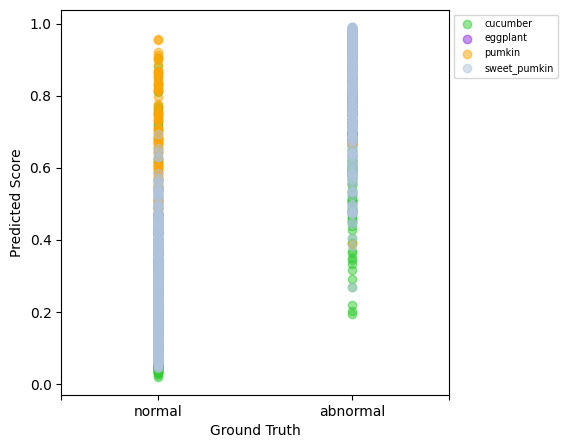

In [25]:
# train
color_list = ['limegreen', 'blueviolet', 'orange', 'lightsteelblue']
plt.figure(figsize=(5, 5))
for idx, obj in enumerate(obj_list):
    plt.scatter(train_results[obj]['gt_sp'], train_results[obj]['pr_sp'], color=color_list[idx], label=obj, alpha=0.5)
plt.legend(fontsize='x-small', bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Score')
plt.xticks([-0.5, 0, 1, 1.5], labels=['', 'normal', 'abnormal', ''])
plt.show()

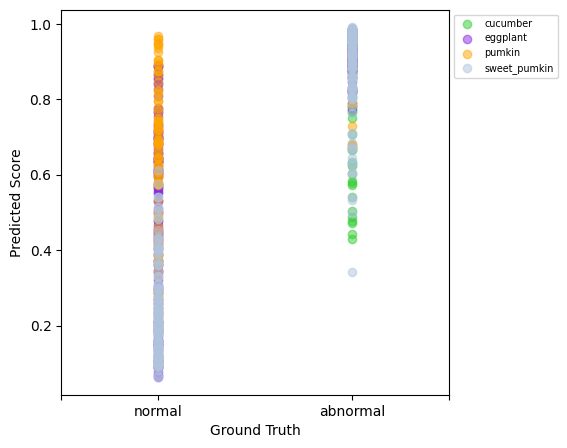

In [26]:
# test 
color_list = ['limegreen', 'blueviolet', 'orange', 'lightsteelblue']
plt.figure(figsize=(5, 5))
for idx, obj in enumerate(obj_list):
    plt.scatter(test_results[obj]['gt_sp'], test_results[obj]['pr_sp'], color=color_list[idx], label=obj, alpha=0.5)
plt.legend(fontsize='x-small', bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Score')
plt.xticks([-0.5, 0, 1, 1.5], labels=['', 'normal', 'abnormal', ''])
plt.show()

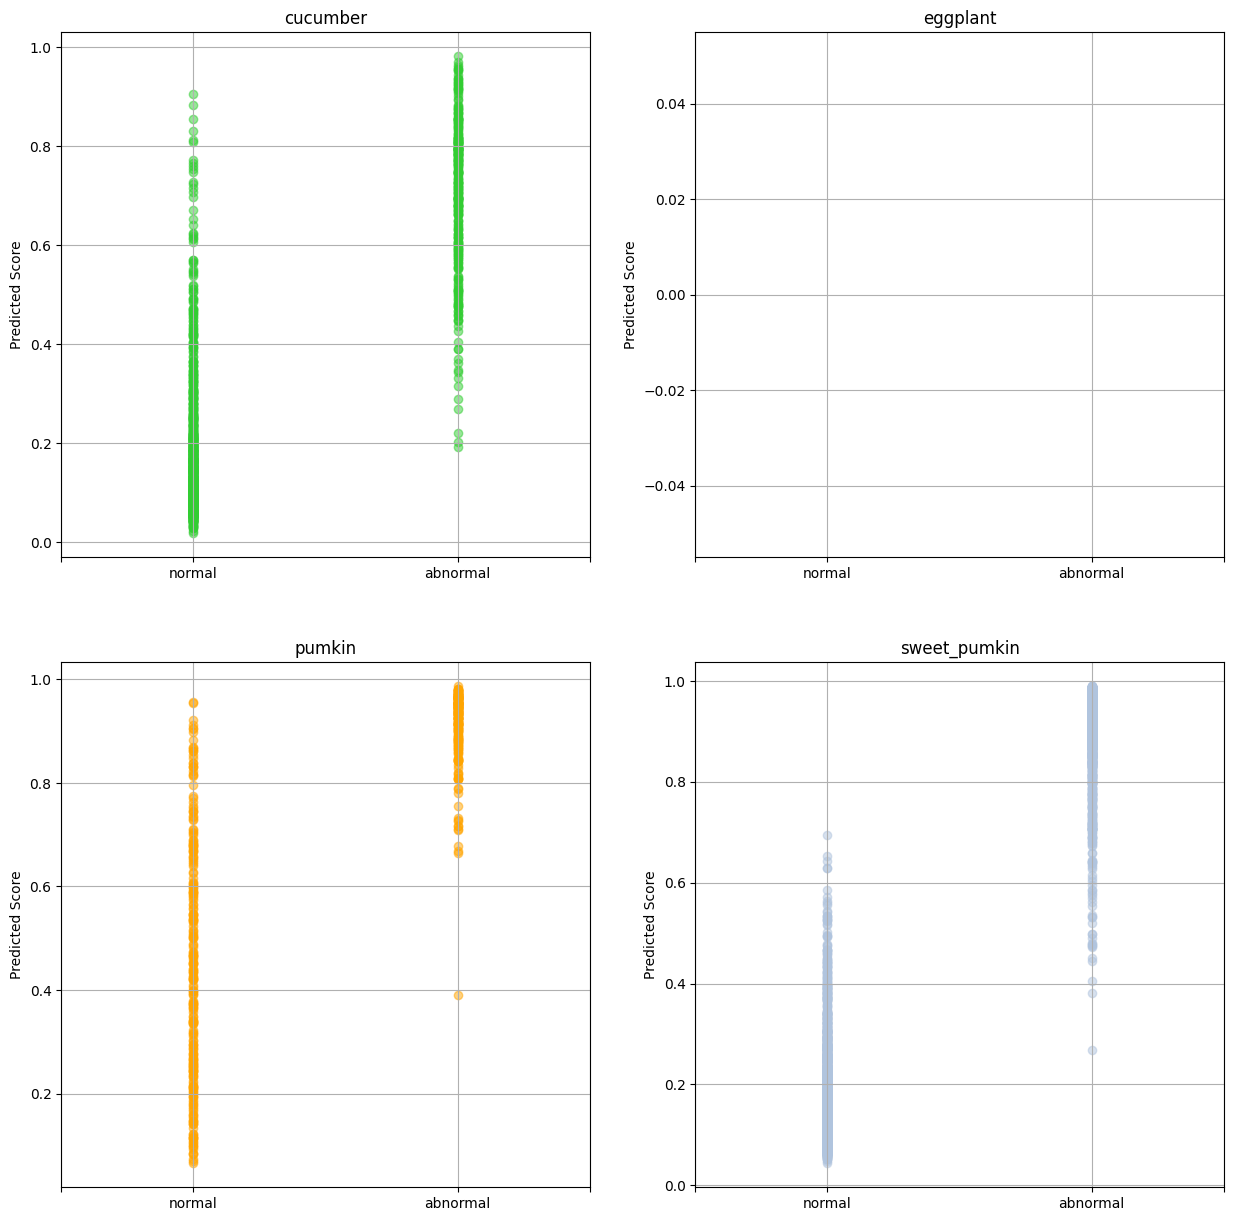

In [27]:
# train
plt.figure(figsize=(15, 15))

for idx, obj in enumerate(obj_list):
    
    plt.subplot(2, 2, idx+1)

    plt.scatter(train_results[obj]['gt_sp'], train_results[obj]['pr_sp'], color=color_list[idx], label=obj, alpha=0.5)
    plt.title(obj)
    plt.ylabel('Predicted Score')
    plt.grid()
    plt.xticks([-0.5, 0, 1, 1.5], labels=['', 'normal', 'abnormal', ''])
# plt.suptitle("Train set socre scatter plot (per class)")
plt.show()

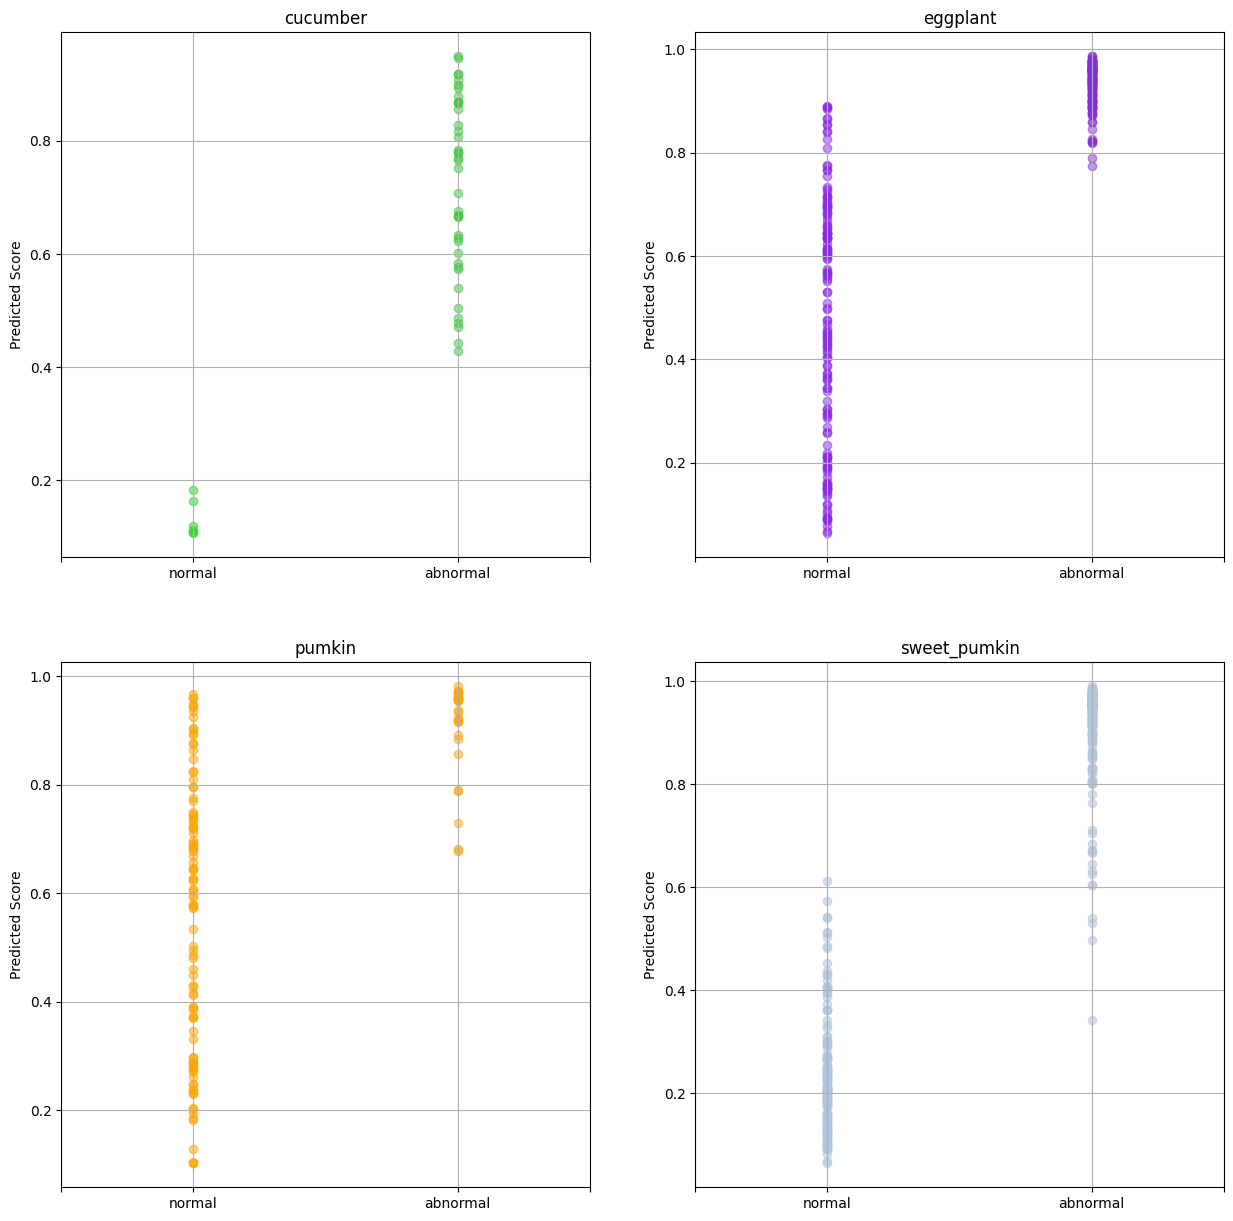

In [28]:
# test
plt.figure(figsize=(15, 15))

for idx, obj in enumerate(obj_list):
    
    plt.subplot(2, 2, idx+1)

    plt.scatter(test_results[obj]['gt_sp'], test_results[obj]['pr_sp'], color=color_list[idx], label=obj, alpha=0.5)
    plt.title(obj)
    plt.ylabel('Predicted Score')
    plt.grid()
    plt.xticks([-0.5, 0, 1, 1.5], labels=['', 'normal', 'abnormal', ''])
# plt.suptitle("Train set socre scatter plot (per class)")
plt.show()

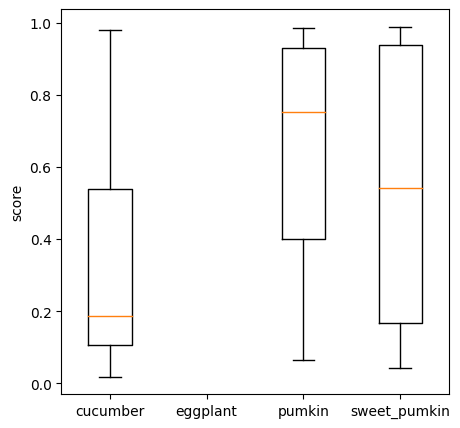

In [29]:
# train
plt.figure(figsize=(5, 5))
plt.boxplot([train_results[obj]['pr_sp'] for obj in obj_list])
plt.xticks([1, 2, 3, 4 ], obj_list)
plt.ylabel('score')
# plt.title("Train set score box plot", fontsize=20)
plt.show()

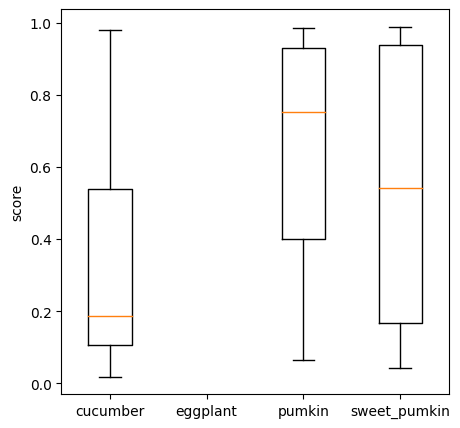

In [30]:
# test
plt.figure(figsize=(5, 5))
plt.boxplot([train_results[obj]['pr_sp'] for obj in obj_list])
plt.xticks([1, 2, 3, 4 ], obj_list)
plt.ylabel('score')
plt.show()

##### (2) qhat

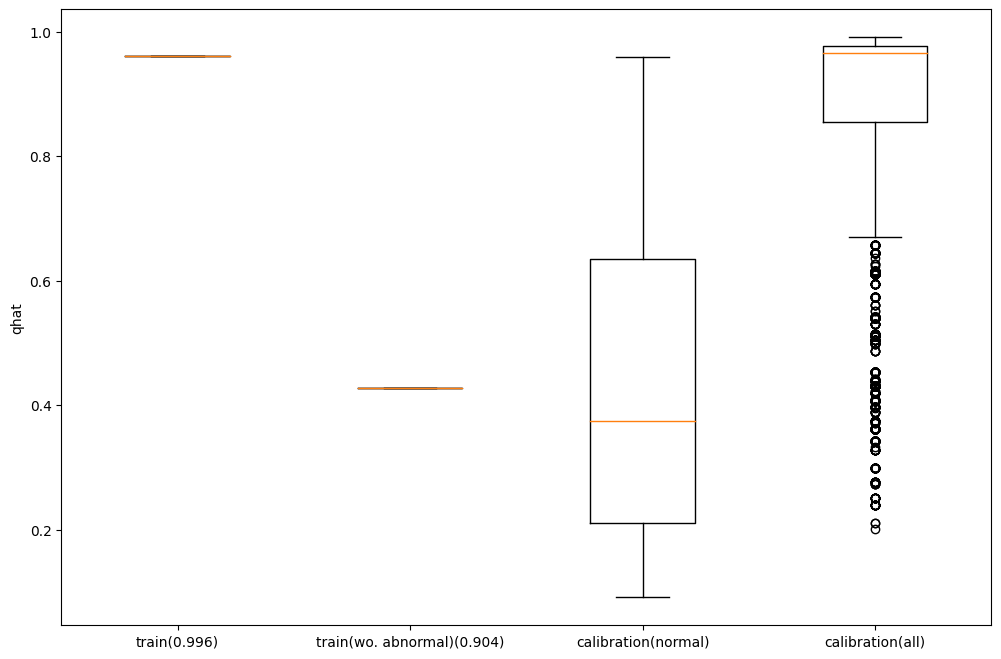

In [31]:
plt.figure(figsize=(12, 8))
plt.boxplot([train_qhat, train_qhat_wo_n, normal_all_qhat,  all_all_qhat])
plt.xticks([1, 2, 3, 4 ], ['train(0.996)',  'train(wo. abnormal)(0.904)', 'calibration(normal)', 'calibration(all)'])
plt.ylabel('qhat')
plt.show()

---
# 5. conformal p-value

#### 4. Computing marginal conformal p-values

In [32]:
from cccpv.models import ToyModel
from cccpv.methods import ConformalPvalues
from cccpv.methods import calibrate_ccv

In [42]:
scores_test = 1 - np.array(y_score_list)
scores_cal = 1 - np.array(scores)

scores_cal_mat = np.tile(scores_cal, (len(scores_test), 1))
pvals_numerator = np.sum(scores_cal_mat <= scores_test.reshape(len(scores_test),1), 1) # 각 행에서 scores_test 값 보다 작은것들의 개수
pvals_marginal = (1.0+pvals_numerator)/(1.0+len(scores_cal))

In [43]:
scores_test.shape

(793,)

In [44]:
is_outlier = np.zeros(len(scores_test))
is_outlier[np.where(y_true_np == 1)[0]] = 1
print(np.where(y_true_np == 1)[0])
print(is_outlier)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 346 347 348 349 350 351 352 353
 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371
 372 373 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489
 490 491 492 493 494 495 496 497 498 499 500 501 50

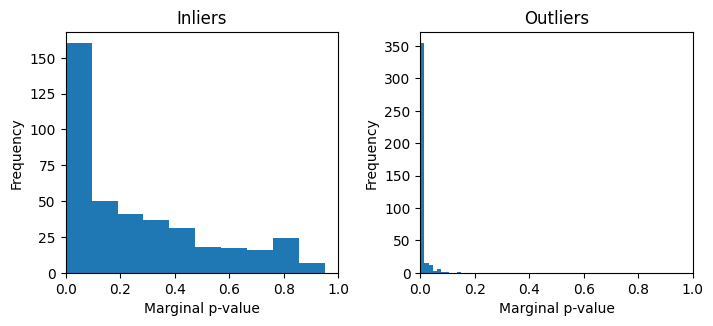

In [45]:
# Histogram of marginal p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

axs[0].hist(pvals_marginal[np.where(y_true_np == 0)[0]])
axs[0].set_xlabel("Marginal p-value")
axs[0].set_ylabel("Frequency")
axs[0].title.set_text('Inliers')
axs[0].set_xlim([0,1])

axs[1].hist(pvals_marginal[is_outlier==1])
axs[1].set_xlabel("Marginal p-value")
axs[1].set_ylabel("Frequency")
axs[1].title.set_text('Outliers')
axs[1].set_xlim([0,1])

plt.show()

In [49]:
pred_pvals_marginal = pvals_marginal<0.05

p = precision_score(y_true_np, pred_pvals_marginal, zero_division=0)

r = recall_score(y_true_np, pred_pvals_marginal, zero_division=0)

print(f'precision: {round(p, 3)}\nrecall: {round(r, 3)}')

precision: 0.751
recall: 0.972


In [59]:
y_true = []
y_score_list = []
for obj in obj_list:
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = sorted(list(zip(y_true, y_score_list)))

print(f'정상 개수 ===> {count} \n전체개수 ===> {len(y_all)} \n')
normal_all_qhat = []
alpha = 0.1

for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(count-n):
        scores_test = 1 - np.array(y_score_list)
        scores_cal = 1 - np.array(scores)
        scores_cal = 1-np.array(y_all[i:i + n])[:, 1]
        
        scores_test = 1-np.array(y_all[:i] + y_all[i + n:])[:, 1]
        y_label = np.array(y_all[:i] + y_all[i + n:])[:, 0]

        scores_cal_mat = np.tile(scores_cal, (len(scores_test), 1))
        pvals_numerator = np.sum(scores_cal_mat <= scores_test.reshape(len(scores_test),1), 1) # 각 행에서 scores_test 값 보다 작은것들의 개수
        pvals_marginal = (1.0+pvals_numerator)/(1.0+len(scores_cal))

        y_pred = pvals_marginal < 0.05
        p = precision_score(y_label, y_pred, zero_division=0)
        p_list.append(p)


        r = recall_score(y_label, y_pred, zero_division=0)
        r_list.append(r)
        # Histogram of marginal p-values
        fig, axs = plt.subplots(1,2, figsize=(7,3))
        fig.tight_layout()
        plt.subplots_adjust(wspace=0.3)
        plt.suptitle(f'n:{n}, i:{i}', fontsize=14)

        axs[0].hist(pvals_marginal[y_label==0])
        axs[0].set_xlabel("Marginal p-value")
        axs[0].set_ylabel("Frequency")
        axs[0].title.set_text('Inliers')
        axs[0].set_xlim([0,1])

        axs[1].hist(pvals_marginal[y_label==1])
        axs[1].set_xlabel("Marginal p-value")
        axs[1].set_ylabel("Frequency")
        axs[1].title.set_text('Outliers')
        axs[1].set_xlim([0,1])
        
        plt.savefig(f'./cal_p_crop/n_{n}_i_{i}.png', bbox_inches='tight', dpi=300)
        plt.close()

    print(f'---{n}---')
    # print(f'score_list\n{len(score_list)}\n')
    # print('q_hat 개수', len(normal_all_qhat))
    # print('p_list', len(p_list))
    # print('y_true', len(y_true))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

정상 개수 ===> 401 
전체개수 ===> 793 

---10---
precision: 0.0 
recall: 0.0


---15---
precision: 0.0 
recall: 0.0


---20---
precision: 0.6946 
recall: 0.9582


---25---
precision: 0.6971 
recall: 0.9576


---30---
precision: 0.6996 
recall: 0.957


---35---
precision: 0.7021 
recall: 0.9565


---40---
precision: 0.7048 
recall: 0.9578


---45---
precision: 0.7073 
recall: 0.9572


---50---
precision: 0.7099 
recall: 0.9566


---55---
precision: 0.7126 
recall: 0.956




##### Benjamini-Hochberg 

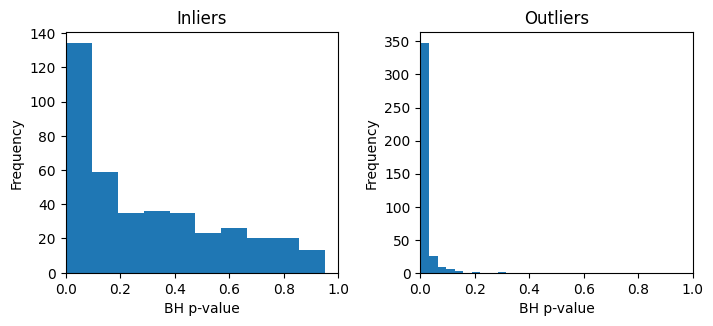

In [52]:
pvals_marginal_sorted = np.sort(pvals_marginal)
m = len(pvals_marginal)

pvals_marginal_bh = np.minimum(1, pvals_marginal_sorted * (m / np.arange(1, m + 1)))
# pvals_marginal_bh = pvals_marginal_sorted * (m / np.arange(1, m + 1))

pvals_marginal_bh_full = np.empty_like(pvals_marginal)
pvals_marginal_bh_full[np.argsort(pvals_marginal)] = pvals_marginal_bh

# Histogram of marginal p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

axs[0].hist(pvals_marginal_bh_full[is_outlier==0])
axs[0].set_xlabel("BH p-value")
axs[0].set_ylabel("Frequency")
axs[0].title.set_text('Inliers')
axs[0].set_xlim([0,1])

axs[1].hist(pvals_marginal_bh_full[is_outlier==1])
axs[1].set_xlabel("BH p-value")
axs[1].set_ylabel("Frequency")
axs[1].title.set_text('Outliers')
axs[1].set_xlim([0,1])

plt.show()

In [51]:
pred_marginal_bh_full = pvals_marginal_bh_full<0.05

p = precision_score(y_true_np, pred_marginal_bh_full, zero_division=0)

r = recall_score(y_true_np, pred_marginal_bh_full, zero_division=0)

print(f'precision: {round(p, 3)}\nrecall: {round(r, 3)}')

precision: 0.827
recall: 0.913


In [61]:
y_true = []
y_score_list = []
for obj in obj_list:
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = sorted(list(zip(y_true, y_score_list)))

print(f'정상 개수 ===> {count} \n전체개수 ===> {len(y_all)} \n')

for n in range(10, 60, 5):
    p_list = []
    r_list = []
    for i in range(count-n):
        scores_test = 1 - np.array(y_score_list)
        scores_cal = 1 - np.array(scores)
        scores_cal = 1-np.array(y_all[i:i + n])[:, 1]
        
        scores_test = 1-np.array(y_all[:i] + y_all[i + n:])[:, 1]
        y_label = np.array(y_all[:i] + y_all[i + n:])[:, 0]

        scores_cal_mat = np.tile(scores_cal, (len(scores_test), 1))
        pvals_numerator = np.sum(scores_cal_mat <= scores_test.reshape(len(scores_test),1), 1) # 각 행에서 scores_test 값 보다 작은것들의 개수
        pvals_marginal = (1.0+pvals_numerator)/(1.0+len(scores_cal))

        pvals_marginal_sorted = np.sort(pvals_marginal)
        m = len(pvals_marginal)

        pvals_marginal_bh = np.minimum(1, pvals_marginal_sorted * (m / np.arange(1, m + 1)))
        # pvals_marginal_bh = pvals_marginal_sorted * (m / np.arange(1, m + 1))

        pvals_marginal_bh_full = np.empty_like(pvals_marginal)
        pvals_marginal_bh_full[np.argsort(pvals_marginal)] = pvals_marginal_bh

        y_pred = pvals_marginal_bh_full < 0.05
        p = precision_score(y_label, y_pred, zero_division=0)
        p_list.append(p)


        r = recall_score(y_label, y_pred, zero_division=0)
        r_list.append(r)
        # Histogram of marginal p-values
        fig, axs = plt.subplots(1,2, figsize=(7,3))
        fig.tight_layout()
        plt.subplots_adjust(wspace=0.3)
        plt.suptitle(f'n:{n}, i:{i}', fontsize=14)

        axs[0].hist(pvals_marginal_bh_full[y_label==0])
        axs[0].set_xlabel("BH p-value")
        axs[0].set_ylabel("Frequency")
        axs[0].title.set_text('Inliers')
        axs[0].set_xlim([0,1])

        axs[1].hist(pvals_marginal_bh_full[y_label==1])
        axs[1].set_xlabel("BH p-value")
        axs[1].set_ylabel("Frequency")
        axs[1].title.set_text('Outliers')
        axs[1].set_xlim([0,1])
        
        plt.savefig(f'./bh_p_crop/n_{n}_i_{i}.png', bbox_inches='tight', dpi=300)
        plt.close()

    print(f'---{n}---')
    # print(f'score_list\n{len(score_list)}\n')
    # print('q_hat 개수', len(normal_all_qhat))
    # print('p_list', len(p_list))
    # print('y_true', len(y_true))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

정상 개수 ===> 401 
전체개수 ===> 793 

---10---
precision: 0.0 
recall: 0.0


---15---
precision: 0.0 
recall: 0.0


---20---
precision: 0.0001 
recall: 0.0


---25---
precision: 0.009 
recall: 0.0031


---30---
precision: 0.0694 
recall: 0.0124


---35---
precision: 0.1827 
recall: 0.0325


---40---
precision: 0.2825 
recall: 0.0774


---45---
precision: 0.398 
recall: 0.1703


---50---
precision: 0.4801 
recall: 0.2516


---55---
precision: 0.5144 
recall: 0.3134




#### 6. Numerical experiments


In [40]:
# from utils_experiments import evaluate_all_methods

# def run_experiment(model, method_oneclass, alpha=0.1, random_state=2021, purity=0.9, num_test=10):   
#     # Sample training data
#     data, _ = model.sample(n, random_state=random_state)

#     # Initialize the one-class classifier
#     contamination = 0.001
#     contamination = min(max(contamination,0.004),0.1)
#     if method_oneclass == "SVM":
#         classifier = svm.OneClassSVM(nu=contamination, kernel="rbf", gamma=0.1)
#     if method_oneclass == "IForest":
#         classifier = IsolationForest(random_state=random_state, contamination=contamination, behaviour="new")
#     if method_oneclass == "Neighbors":
#         classifier = LocalOutlierFactor(novelty=True, contamination=contamination)
        
#     # Calibrate the conformal classifier
#     cc = ConformalPvalues(data, classifier, calib_size=0.5, delta = 0.05, random_state=random_state)

#     # Evaluate performance on test data
#     results = pd.DataFrame({})
#     for test_index in range(num_test):
#         # Sample test data
#         random_state_new = random_state + 10000 * test_index
#         data_test, is_outlier = model.sample(n, purity=purity, random_state=random_state_new)
        
#         # Compute p-values on test data
#         pvals_one_class = cc.predict(data_test, simes_kden=2)

#         # Evaluate performance
#         res = evaluate_all_methods(pvals_one_class, is_outlier, alpha=alpha)

#         # Store results
#         res['Amplitude'] = model.a
#         res['Data-index'] = random_state
#         res['Test-index'] = test_index
#         results = pd.concat([results, res])
    
#     return results

In [41]:
# num_data = 100 # Number of data sets to simulate
# num_test = 10  # Number of test sets to simulate for each data set
# purity = 0.9   # Proportion of outliers in test data
# a = 2.5        # Outlier signal strength

# # Initialize data model
# model = ToyModel(p, a)

# # Choose a one-class classifier algorithm
# method_oneclass = "SVM"

# # Run all the experiments
# results = pd.DataFrame({})
# for train_index in tqdm(range(num_data)):
#     res = run_experiment(model, method_oneclass, random_state=train_index, purity=purity, num_test=num_test)
#     results = pd.concat([results, res])